# Time Series Analysis - ARIMA
#### Source: Atwan, Tarek A.. Time Series Analysis with Python Cookbook: Practical recipes for exploratory data analysis, data preparation, forecasting, and model evaluation. Packt Publishing. Kindle Edition. 

In [504]:
# Import libraries

import pandas as pd 
import numpy as np 
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt 
import warnings 
import statsmodels.api as sm
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tsa.api import AutoReg
from statsmodels.tools.eval_measures import rmspe, rmse 
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, normaltest
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from itertools import product 
warnings.filterwarnings('ignore') 
plt.rcParams["figure.figsize"] = [12, 7]

In [528]:
# Read in time series using pandas datareader. 

start = ('01-01-1990')
end = ('09-02-2022')

df = pdr.DataReader('SPY','yahoo',start, end).asfreq('M').ffill() # set freq to monthly
df['return'] = pd.DataFrame(df['Adj Close']).pct_change()
df = df.dropna()
df['cumret'] = (1+df['return']).cumprod() # calculate cumulative return
df = df['cumret']
df

Date
1993-04-30     0.974412
1993-05-31     0.974412
1993-06-30     1.004302
1993-07-31     1.004302
1993-08-31     1.037732
                ...    
2022-04-30    17.108289
2022-05-31    15.641940
2022-06-30    14.352099
2022-07-31    14.352099
2022-08-31    15.034227
Freq: M, Name: cumret, Length: 353, dtype: float64

In [506]:
# Check stationarity of time series

def check_stationarity(df): 
    results = adfuller(df)[1:3] 
    s = 'Non-Stationary' 
    if results[0] < 0.05:
        s = 'Stationary' 
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [507]:
# Split data into train and test sets

def split_data(data, test_split): 
    l = len(data) 
    t_idx = round(l*(1-test_split)) 
    train, test = data[ : t_idx], data[t_idx : ] 
    print(f'train: {len(train)} , test: {len(test)}') 
    return train, test

In [508]:
# Define test size of dataset

test = 0.15
train, test = split_data(df, test) 

train: 300 , test: 53


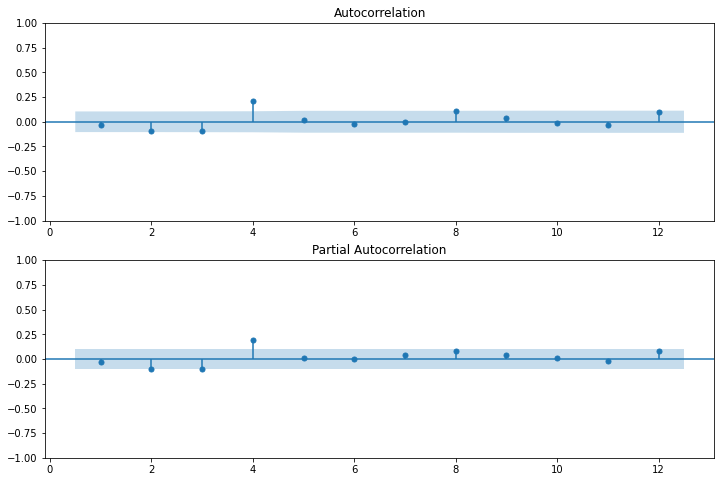

In [509]:
# Difference timeseries and check autocorrelation 

df_diff = df.diff().dropna() 
fig, ax = plt.subplots(2,1, figsize=(12,8)) 
plot_acf(df_diff, zero=False, ax=ax[0], lags=12) 
plot_pacf(df_diff, zero=False, ax=ax[1], lags=12) 
plt.show()

In [510]:
# Combinator function that will be used to search for the optimal ARIMA model

def combinator(items):
    combo = [i for i in product(*items)] 
    return combo

In [511]:
# Check stationarity of time series

check_stationarity(df)

'Non-Stationary	 p-value:0.9964106885843717 	 lags:14


('Non-Stationary', 0.9964106885843717)

In [512]:
# Check stationarity of differenced time series

check_stationarity(df_diff)

'Stationary	 p-value:0.0016460047011371101 	 lags:15


('Stationary', 0.0016460047011371101)

In [513]:
# Function to test normality of time series

def is_normal(test, p_level=0.05): 
    stat, pval = test 
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [514]:
# Normal distribution using Shapiro test

normal_args = (np.mean(df),np.std(df)) 
print(is_normal(shapiro(df))) 

Not Normal


In [515]:
# Test normality of residuals

model = AutoReg(df, lags=12).fit()
print(is_normal(shapiro(model.resid)))

Not Normal


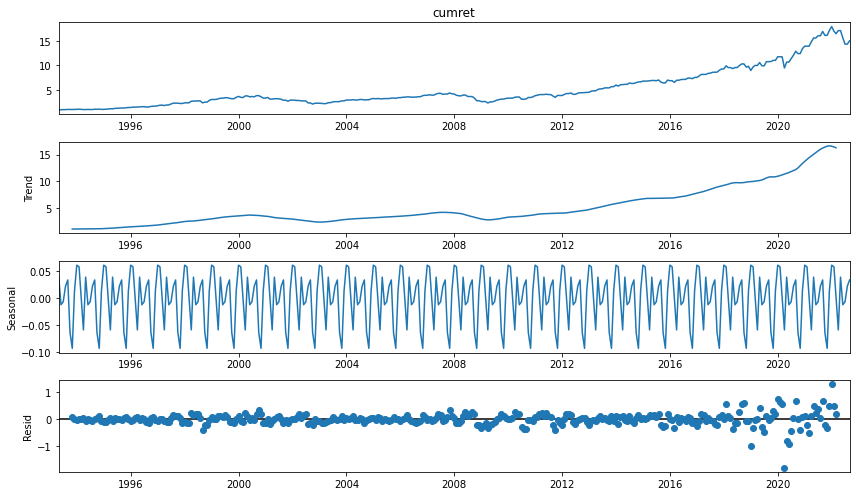

In [516]:
# Decompose time series

decomposed = seasonal_decompose(df, period=12)
decomposed.plot()
plt.show()

In [517]:
# Select best performing ARIMA model

def get_best_model(score, c='AIC'): 
    initial_score = score[0][c] 
    best_model = 0 
    for k,v in score.items(): 
        if v[c] < initial_score: 
            initial_score = v[c] 
            best_model = k 
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}') 
    return score[best_model]['model']

In [518]:
# Get the best perfoming ARIMA by score

pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ]) 
score = {} 
for i, (p, d, q) in enumerate(vals): 
    m = ARIMA(train, order=(p,d,q)) 
    res = m.fit() 
    y = train.values.ravel()  
    y_hat = res.forecast(steps=len(y)) 
    score[i] = {'order': (p,d,q), 
    'AIC':res.aic,  
    'RMSPE': rmspe(y, y_hat), 
    'BIC': res.bic, 
    'AICc':res.aicc, 
    'RMSE' : rmse(y, y_hat), 
    'MAPE' : mape(y, y_hat), 
    'model': res}

best_model = get_best_model(score, 'AIC') # select which score to use for ranking model

Best model: 13 with lowest AIC score: -287.3902203360812


In [519]:
# Ranked models by score

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,13,"(1, 1, 1)",-287.39022,44.448799,-276.28889,-287.308864,11.217553,3.926439,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",-287.280342,39.16741,-272.478567,-287.144287,8.423658,3.19654,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,22,"(2, 1, 1)",-287.136725,39.771266,-272.334951,-287.000671,8.716381,3.28052,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",-285.722983,42.506715,-267.220765,-285.518205,10.163158,3.666245,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,7,"(0, 2, 1)",-285.687275,56.880457,-278.293088,-285.646597,18.14993,5.405369,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [520]:
# Fit ARIMA model

model = ARIMA(train, order=(1,1,1)) 
results = model.fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 cumret   No. Observations:                  300
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 146.695
Date:                Wed, 07 Sep 2022   AIC                           -287.390
Time:                        21:56:32   BIC                           -276.289
Sample:                    04-30-1993   HQIC                          -282.947
                         - 03-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9921      0.016     61.522      0.000       0.961       1.024
ma.L1         -0.9614      0.029    -33.105      0.000      -1.018      -0.905
sigma2         0.0219      0.001     18.161      0.000       0.020       0.024
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                85.66
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

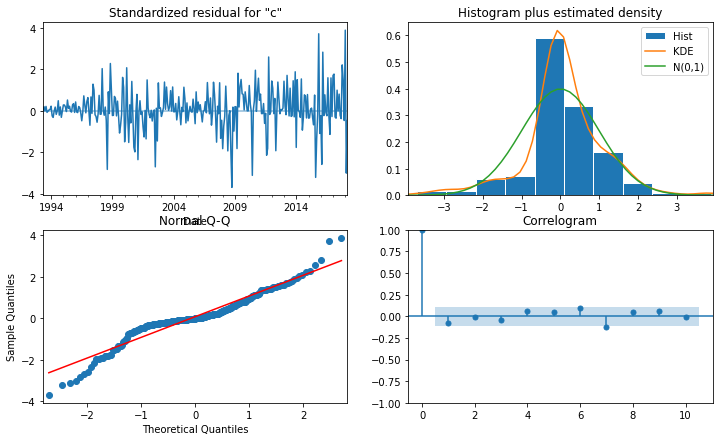

In [521]:
# Plot model results

results.plot_diagnostics()
plt.show()

In [522]:
# Test autocorrelation of residuals

(acorr_ljungbox(results.resid, lags=12, return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [525]:
# Create a dataframe of actual (test) vs predicted variable

forecast = pd.DataFrame(results.forecast(test.shape[0]))
forecast = forecast.reset_index().drop(columns='index')
test = test.reset_index() 
forecast = pd.concat([test,forecast], axis=1)
forecast = forecast.set_index('Date')
forecast.head()

,index,cumret,predicted_mean
Date,,,
2018-04-30,0,9.357069,9.638690
2018-05-31,1,9.584530,9.705537
2018-06-30,2,9.584530,9.771858
2018-07-31,3,9.996767,9.837658
2018-08-31,4,10.315862,9.902940


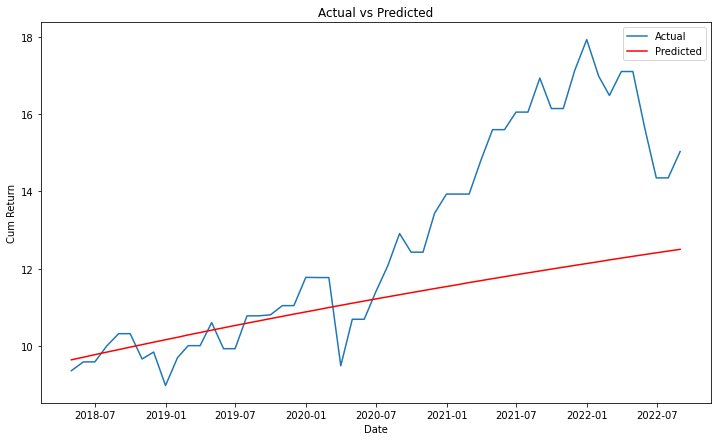

In [526]:
# Plot Actual vs Predicted values based on test values

plt.plot(forecast['cumret'])
plt.plot(forecast['predicted_mean'], color='r')
plt.xlabel('Date')    
plt.ylabel('Cum Return')
plt.title('Actual vs Predicted')
plt.legend(['Actual', 'Predicted'])    
plt.show()